In [1]:
import os
import math
import time

from PIL import Image
from config import BASE_DIR
import numpy as np
import matplotlib.pyplot as plt
from src.ml.scripts.predict import predict
from scipy.ndimage import measurements, zoom

In [2]:
image = Image.open(os.path.join(BASE_DIR, 'data/satellite_images/ld.tif'))

tile_size = 50

image_size = list(map(lambda x : math.floor(x / 50), image.size))

tiles = np.empty(image_size, dtype=object)

for i in range(0, tiles.shape[0]):
    for j in range(0, tiles.shape[1]):
        x = i * tile_size
        y = j * tile_size
        tile = image.crop((x, y, x + tile_size, y + tile_size))
        tiles[i, j] = np.array(tile)

predictions = predict('model1', tiles.flatten())

pred_map = np.array(predictions).reshape(image_size)

Using cache found in /home/witek/.cache/torch/hub/pytorch_vision_v0.10.0
/home/witek/anaconda3/envs/main/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/witek/anaconda3/envs/main/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/tmp/ipykernel_10861/2757601794.py:1: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  pred_map, clusters = measurements.label(pred_map)


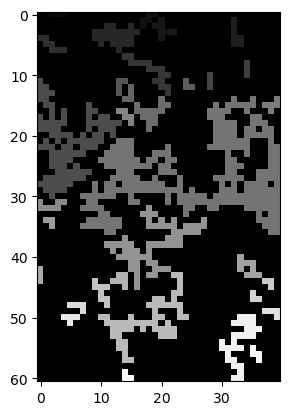

In [23]:
pred_map, clusters = measurements.label(pred_map)
plt.imshow(pred_map * 10, cmap='gray')

In [24]:
clusters_to_filter = [cluster for cluster in np.unique(pred_map) if np.count_nonzero(pred_map == cluster) <= 2]
mask = np.isin(pred_map, clusters_to_filter)
pred_map[mask] = 0
pred_mapT = pred_map.T

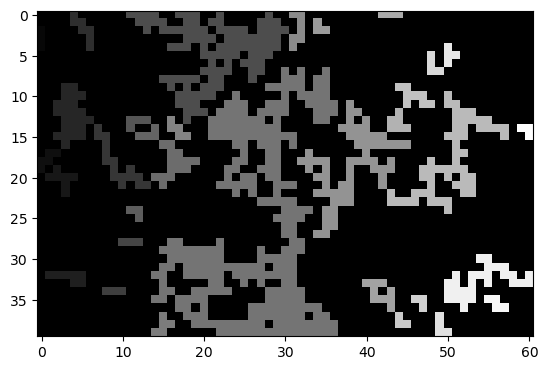

In [25]:
plt.imshow(pred_mapT, cmap='gray')

In [6]:
# SHOW MAP

for i in range(0, pred_map.shape[0]):
    for j in range(0, pred_map.shape[1]):
        x = i * tile_size
        y = j * tile_size

        if pred_map[i, j]:
            region = image.crop((x, y, x + tile_size, y + tile_size))
            red_channel = region.split()[0]
            red_channel = red_channel.point(lambda p: p * 1.5)
            new_region = Image.merge("RGB", (red_channel, region.split()[1], region.split()[2]))
            image.paste(new_region, (x, y, x + tile_size, y + tile_size))

image.show()

In [26]:
areas = {i : [(x, y) for x, y in zip(np.where(pred_map == i)[0], np.where(pred_map == i)[1])] for i in np.unique(pred_map)[1:]}
areas

{1: [(0, 2), (0, 3), (0, 4)],
 2: [(0, 18), (0, 19), (1, 17), (1, 18), (2, 17)],
 3: [(1, 20), (2, 19), (2, 20), (3, 20), (3, 21), (3, 22), (4, 20)],
 4: [(1, 32), (2, 32), (3, 32), (4, 32), (4, 33), (5, 32), (5, 33)],
 5: [(2, 11),
  (2, 12),
  (2, 15),
  (3, 9),
  (3, 10),
  (3, 11),
  (3, 12),
  (3, 13),
  (3, 14),
  (3, 15),
  (3, 16),
  (4, 9),
  (4, 10),
  (4, 11),
  (4, 12),
  (4, 13),
  (4, 14),
  (4, 15),
  (5, 10),
  (5, 12),
  (5, 13),
  (5, 14),
  (5, 15),
  (6, 13)],
 6: [(4, 0), (4, 1), (5, 1), (5, 2), (6, 2), (6, 3), (6, 4)],
 7: [(7, 14),
  (7, 15),
  (8, 15),
  (8, 16),
  (8, 17),
  (8, 18),
  (9, 18),
  (9, 19),
  (9, 20),
  (10, 20),
  (10, 21),
  (11, 19),
  (11, 20),
  (12, 20),
  (12, 21),
  (13, 21)],
 8: [(8, 34), (9, 34), (10, 34)],
 9: [(10, 28), (11, 28), (12, 28)],
 10: [(11, 0),
  (12, 0),
  (12, 1),
  (13, 0),
  (13, 1),
  (13, 2),
  (14, 0),
  (14, 1),
  (15, 1),
  (15, 2),
  (15, 8),
  (16, 2),
  (16, 4),
  (16, 8),
  (16, 9),
  (17, 0),
  (17, 2),
  (17

In [27]:
for key in areas.keys():
    row = areas[key]
    new_row = []
    for x in row:
        new_row.extend([(x[0], x[1]), (x[0] + 1, x[1]), (x[0], x[1] + 1), (x[0] + 1, x[1] + 1)])
    areas[key] = list(set(new_row))

areas

{1: [(1, 2), (0, 4), (1, 5), (0, 3), (1, 4), (0, 2), (0, 5), (1, 3)],
 2: [(1, 18),
  (0, 20),
  (2, 17),
  (3, 17),
  (0, 19),
  (1, 20),
  (2, 19),
  (1, 17),
  (2, 18),
  (0, 18),
  (3, 18),
  (1, 19)],
 3: [(5, 21),
  (4, 23),
  (1, 21),
  (2, 20),
  (3, 23),
  (4, 22),
  (3, 20),
  (1, 20),
  (2, 19),
  (5, 20),
  (4, 21),
  (3, 19),
  (3, 22),
  (2, 21),
  (3, 21),
  (4, 20)],
 4: [(2, 33),
  (5, 34),
  (3, 33),
  (6, 34),
  (4, 32),
  (5, 33),
  (6, 33),
  (1, 33),
  (2, 32),
  (5, 32),
  (4, 34),
  (3, 32),
  (6, 32),
  (1, 32),
  (4, 33)],
 5: [(6, 12),
  (6, 15),
  (4, 9),
  (4, 12),
  (3, 10),
  (3, 16),
  (5, 13),
  (4, 15),
  (3, 13),
  (5, 10),
  (5, 16),
  (2, 11),
  (6, 11),
  (6, 14),
  (7, 13),
  (3, 9),
  (4, 14),
  (3, 12),
  (5, 9),
  (4, 11),
  (4, 17),
  (3, 15),
  (5, 12),
  (5, 15),
  (2, 16),
  (2, 13),
  (6, 13),
  (6, 10),
  (6, 16),
  (3, 11),
  (4, 10),
  (4, 16),
  (3, 14),
  (5, 11),
  (4, 13),
  (3, 17),
  (5, 14),
  (2, 12),
  (2, 15),
  (7, 14)],
 6: 

In [10]:
areas[113]

[(56, 36),
 (57, 36),
 (58, 36),
 (56, 35),
 (57, 35),
 (55, 36),
 (56, 37),
 (55, 35),
 (57, 37),
 (58, 37)]

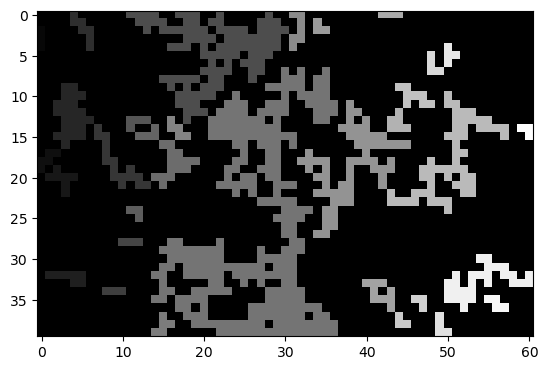

In [28]:
plt.imshow(pred_mapT, cmap='gray')

In [12]:
nmap = zoom(pred_mapT, tile_size, order=0)
nmap[nmap != 0] = 255

In [14]:
# SHOW MAP IMAGE

r, g, b = image.split()
map_image = Image.merge("RGB", (b, g, new_mimg))

map_image.show()


(eog:10902): EOG-CRITICAL **: 12:53:18.096: eog_image_get_file: assertion 'EOG_IS_IMAGE (img)' failed

(eog:10902): GLib-GIO-CRITICAL **: 12:53:18.096: g_file_equal: assertion 'G_IS_FILE (file1)' failed


In [56]:
areas[33]

[(61, 16),
 (60, 14),
 (59, 15),
 (60, 16),
 (61, 15),
 (59, 14),
 (60, 15),
 (61, 14)]

In [68]:
def find_hull(points):
    pts_list = points.copy()
    first_point = sorted(points, key=lambda x : x[0])[0]
    hull = [first_point, ]

    dirs = [(-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1)]
    
    while True:
        
        dir_bias = dirs.index((hull[-2][0] - hull[-1][0], hull[-2][1] - hull[-1][1])) + 1 if len(hull) > 1 else 0
        
        for dir_num in range(len(dirs)):
            
            idx = (dir_bias + dir_num) % len(dirs)
            
            point_to_check = (hull[-1][0] + dirs[idx][0], hull[-1][1] + dirs[idx][1])
            
            if point_to_check in pts_list:
                hull.append(point_to_check)
                pts_list.remove(point_to_check)
                break
            
            if point_to_check in hull:
                return hull


find_hull(areas[33])

[(59, 15),
 (59, 14),
 (60, 14),
 (61, 14),
 (61, 15),
 (61, 16),
 (60, 16),
 (59, 15)]

In [73]:
hulls = [find_hull(areas[area]) for area in areas.keys()]
hulls

[[(0, 4), (0, 3), (0, 2), (1, 2), (1, 3), (1, 4), (1, 5), (0, 5), (0, 4)],
 [(0, 20),
  (0, 19),
  (0, 18),
  (1, 17),
  (2, 17),
  (3, 17),
  (3, 18),
  (2, 19),
  (1, 20),
  (0, 20)],
 [(1, 21),
  (1, 20),
  (2, 19),
  (3, 19),
  (4, 20),
  (5, 20),
  (5, 21),
  (4, 22),
  (4, 23),
  (3, 23),
  (3, 22),
  (2, 21),
  (1, 21)],
 [(1, 33),
  (1, 32),
  (2, 32),
  (3, 32),
  (4, 32),
  (5, 32),
  (6, 32),
  (6, 33),
  (6, 34),
  (5, 34),
  (4, 34),
  (3, 33),
  (2, 33),
  (1, 33)],
 [(2, 11),
  (3, 10),
  (3, 9),
  (4, 9),
  (5, 9),
  (6, 10),
  (6, 11),
  (6, 12),
  (7, 13),
  (7, 14),
  (6, 15),
  (6, 16),
  (5, 16),
  (4, 17),
  (3, 17),
  (2, 16),
  (2, 15),
  (3, 14),
  (2, 13),
  (2, 12),
  (2, 11)],
 [(4, 0),
  (5, 0),
  (6, 1),
  (7, 2),
  (7, 3),
  (7, 4),
  (7, 5),
  (6, 5),
  (6, 4),
  (5, 3),
  (4, 2),
  (4, 1),
  (4, 0)],
 [(7, 16),
  (7, 15),
  (7, 14),
  (8, 14),
  (9, 15),
  (9, 16),
  (9, 17),
  (10, 18),
  (11, 19),
  (12, 19),
  (13, 20),
  (14, 21),
  (14, 22),
  (13,

In [75]:
hulls_scaled = [[(x[0] * tile_size, x[1] * tile_size) for x in hull] for hull in hulls]
hulls_scaled

[[(0, 200),
  (0, 150),
  (0, 100),
  (50, 100),
  (50, 150),
  (50, 200),
  (50, 250),
  (0, 250),
  (0, 200)],
 [(0, 1000),
  (0, 950),
  (0, 900),
  (50, 850),
  (100, 850),
  (150, 850),
  (150, 900),
  (100, 950),
  (50, 1000),
  (0, 1000)],
 [(50, 1050),
  (50, 1000),
  (100, 950),
  (150, 950),
  (200, 1000),
  (250, 1000),
  (250, 1050),
  (200, 1100),
  (200, 1150),
  (150, 1150),
  (150, 1100),
  (100, 1050),
  (50, 1050)],
 [(50, 1650),
  (50, 1600),
  (100, 1600),
  (150, 1600),
  (200, 1600),
  (250, 1600),
  (300, 1600),
  (300, 1650),
  (300, 1700),
  (250, 1700),
  (200, 1700),
  (150, 1650),
  (100, 1650),
  (50, 1650)],
 [(100, 550),
  (150, 500),
  (150, 450),
  (200, 450),
  (250, 450),
  (300, 500),
  (300, 550),
  (300, 600),
  (350, 650),
  (350, 700),
  (300, 750),
  (300, 800),
  (250, 800),
  (200, 850),
  (150, 850),
  (100, 800),
  (100, 750),
  (150, 700),
  (100, 650),
  (100, 600),
  (100, 550)],
 [(200, 0),
  (250, 0),
  (300, 50),
  (350, 100),
  (350, 

In [82]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

image_map = np.zeros_like(image)

polygons = [Polygon(hull) for hull in hulls_scaled]

for i in range(image_map.shape[0]):
    
    print(f'{i}/{image_map.shape[0]}')
    
    for j in range(image_map.shape[1]):
        point = Point(i, j)
        if sum([int(polygon.contains(point)) for polygon in polygons]) > 0:
            image_map[i, j] = 200
            


0/2048
1/2048
2/2048
3/2048
4/2048
5/2048
6/2048
7/2048
8/2048
9/2048
10/2048
11/2048
12/2048
13/2048
14/2048
15/2048
16/2048
17/2048
18/2048
19/2048
20/2048
21/2048
22/2048
23/2048
24/2048
25/2048
26/2048
27/2048
28/2048
29/2048
30/2048
31/2048
32/2048
33/2048
34/2048
35/2048
36/2048
37/2048
38/2048
39/2048
40/2048
41/2048
42/2048
43/2048
44/2048
45/2048
46/2048
47/2048
48/2048
49/2048
50/2048
51/2048
52/2048
53/2048
54/2048
55/2048
56/2048
57/2048
58/2048
59/2048
60/2048
61/2048
62/2048
63/2048
64/2048
65/2048
66/2048
67/2048
68/2048
69/2048
70/2048
71/2048
72/2048
73/2048
74/2048
75/2048
76/2048
77/2048
78/2048
79/2048
80/2048
81/2048
82/2048
83/2048
84/2048
85/2048
86/2048
87/2048
88/2048
89/2048
90/2048
91/2048
92/2048
93/2048
94/2048
95/2048
96/2048
97/2048
98/2048
99/2048
100/2048
101/2048
102/2048
103/2048
104/2048
105/2048
106/2048
107/2048
108/2048
109/2048
110/2048
111/2048
112/2048
113/2048
114/2048
115/2048
116/2048
117/2048
118/2048
119/2048
120/2048
121/2048
122/2048
123

In [83]:
image = Image.open(os.path.join(BASE_DIR, 'data/satellite_images/ld.tif'))

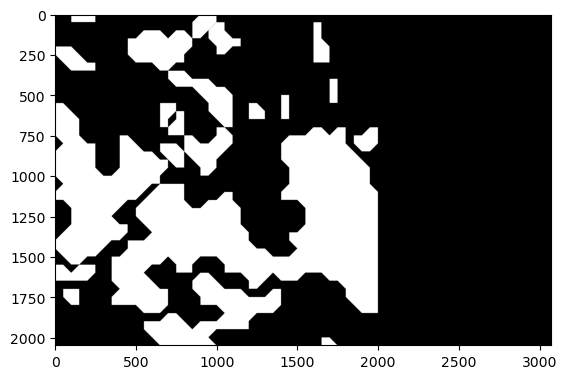

In [105]:
plt.imshow(image_map[:, :, 0], cmap='gray')


In [107]:
mimg = Image.fromarray(image_map[:, :, 0])
new_mimg = Image.new("L", image.size)
new_mimg.paste(mimg, (0, 0))
new_mimg.show()

r, g, b = image.split()
map_image = Image.merge("RGB", (b, g, new_mimg))
map_image.show()